In [1]:
import os
import sys
sys.path.append('../codes')

import numpy as np

import cv2
import glob
from PIL import Image

import matplotlib.pyplot as plt

from utils.img_utils import add_bboxes_on_image

In [2]:
root_dir = "../data/data_aug/GAN"
img_dir = os.path.join(root_dir,"harmonized_frames" )
annot_dir = os.path.join(root_dir, "annotation" )

In [3]:
list_imgs = glob.glob(os.path.join(img_dir, '*.png'))
img_idx = 0

In [4]:
list_imgs

['../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_146_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_191_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_940_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0019_frame_775_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0025_frame_4788_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0025_frame_5149_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_501_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0027_frame_2757_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_646_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_865_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0025_frame_5749_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0027_frame_5149_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0038_frame_2340_4.png',
 '../data/data_aug/GAN/harmonized_frames/DJI_0039_frame_8279_4.png',
 '../data/data_aug/GAN/harmonized_frames/

In [5]:
def get_bboxes(annot_path):    
    with open(annot_path, 'r') as marks:
        bboxes = {}    
        for mark in marks.readlines():                                                          
            rect = mark.replace('\n','').split('\t')          
            objid,x,y,w,h = map(float,rect)             
            bboxes[f'tire-{int(objid):02d}'] = [x, y, x+w, y+h]
        
    return bboxes

def get_img_size(datapath):
    img_pil = Image.open(datapath)
    width, height = img_pil.size
    return width, height
    

0 ../data/data_aug/GAN/harmonized_frames/DJI_0018_frame_146_4.png


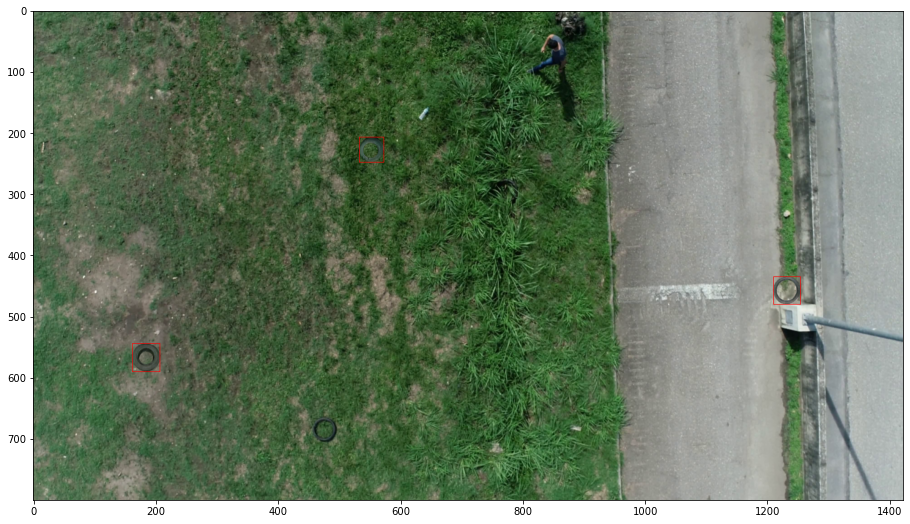

In [6]:
# reset index (we only have 20 images)
if img_idx >= 20: img_idx = 0

img = cv2.imread(list_imgs[img_idx])[:,:,::-1]


print(img_idx, list_imgs[img_idx])
annot_filename = os.path.basename(list_imgs[img_idx]).replace('_4.png', '.txt')
annot_file = os.path.join(annot_dir, annot_filename)

bboxes = get_bboxes(annot_file)
        
plt.figure(figsize=(16,9))
img_bbox = add_bboxes_on_image(np.array(img), bboxes, color=(0, 0, 255), thickness=1)
plt.imshow(img_bbox)
plt.show()

img_idx += 1

In [7]:
from convert_mosquitoes_to_coco import Convert2Coco

In [8]:
coco_format = Convert2Coco()

In [9]:
for img_path in list_imgs:
        
    img_name = os.path.basename(img_path)
    
    annot_filename = os.path.basename(img_path).replace('_4.png', '.txt')
    annot_filepath = os.path.join(annot_dir, annot_filename)

    
    bboxes = get_bboxes(annot_filepath)
    w,h = get_img_size(img_path)
    
    coco_format.update(img_name, w, h, bboxes)
    
    
coco_format.export(os.path.join(img_dir, 'gan_v0.json'))

In [10]:
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.structures.boxes import Boxes, BoxMode, pairwise_iou

import torch

In [11]:
dataset_name = 'ganV0'
register_coco_instances(dataset_name, {}, os.path.join(img_dir, 'gan_v0.json'), img_dir )

In [12]:
dataset = dataset_name
data = get_detection_dataset_dicts([dataset], filter_empty=True)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [13]:
data[12]

{'file_name': '../data/data_aug/GAN/harmonized_frames/DJI_0038_frame_2340_4.png',
 'height': 800,
 'width': 1422,
 'image_id': 12,
 'annotations': [{'iscrowd': 0,
   'bbox': [321.0, 78.0, 48.0, 48.0],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [804.0, 408.0, 47.0, 47.0],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [1145.0, 128.0, 47.0, 47.0],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

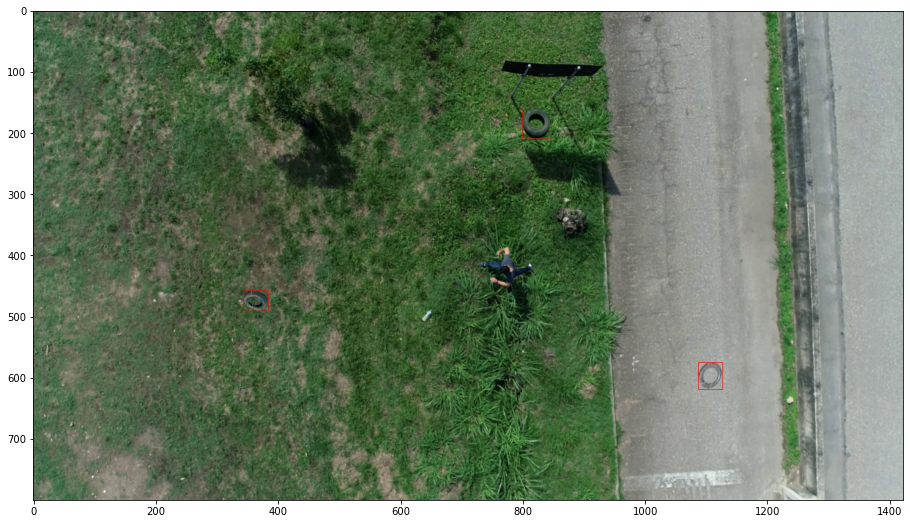

In [16]:
img_ind = 1
sample = data[img_ind]
        
img = Image.open(sample['file_name'])
targets = sample['annotations']
idx = sample['image_id']  

bbs_gt = (torch.tensor([d['bbox'] for d in targets])) 

if len(bbs_gt):
    bbs_gt = BoxMode.convert(bbs_gt, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
    img_bbox = add_bboxes_on_image(np.array(img), bbs_gt, color=(0, 0, 255), thickness=1)

# plot image
plt.figure(figsize=(16,9))
plt.imshow(img_bbox)
plt.show() 